# Example JUSTICE

In [1]:
from src.economy.neoclassical import NeoclassicalEconomyModel
from src.emissions.emission import OutputToEmissions
#from economy.neoclassical import NeoclassicalEconomyModel
from src.data_loader import DataLoader
from src.enumerations import *
from src.model_time import TimeHorizon
from src.climate.temperature_downscaler import TemperatureDownscaler
# Instantiate the data loader
from src.climate.coupled_fair import CoupledFAIR
from src.enumerations import *
import pandas as pd
import numpy as np
from src.damage.kalkuhl import DamageKalkuhl
from src.abatement.abatement_enerdata import AbatementEnerdata
from src.model import JUSTICE




## 1. Initialisation

In [2]:



# Load the data
data_loader = DataLoader()

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

# climate = CoupledFAIR()
# downscaler = TemperatureDownscaler(input_dataset = data_loader)

# climate.fair_justice_run_init(time_horizon=time_horizon, scenarios=scenarios)
# no_of_ensembles = climate.__getattribute__('number_of_ensembles')
# print(no_of_ensembles)
# damage_function = DamageKalkuhl(input_dataset=data_loader, time_horizon=time_horizon, climate_ensembles=no_of_ensembles)
# abatement = AbatementEnerdata(input_dataset=data_loader, time_horizon=time_horizon)

# economy = NeoclassicalEconomyModel(input_dataset = data_loader, time_horizon=time_horizon, climate_ensembles=no_of_ensembles)
# emissions = OutputToEmissions(input_dataset=data_loader, time_horizon=time_horizon, climate_ensembles=no_of_ensembles)

### Lever: Fixed Savings rate

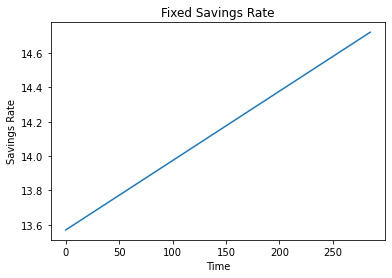

(57, 286)


In [3]:

#Create a fixed savings rate
fixed_savings_rate = np.copy(data_loader.SAVING_RATE_INIT_ARRAY).reshape(-1, 1)
#fixed_savings_rate Validated with RICE50 for timestep 1 and 5

set_year = time_horizon.model_time_horizon
#economy.get_optimal_long_run_savings_rate() = 0.2582781457

for i, years in enumerate(set_year):
    
    t = i+1 #index starts at 0, so add 1 to get the year

    if t != 1: # no need to repeat for the first year

        next_rate = data_loader.SAVING_RATE_INIT_ARRAY + (0.2582781457  - data_loader.SAVING_RATE_INIT_ARRAY)*((t - 1)/(len(set_year) - 1))
        # append to the fixed savings rate array for each year
        fixed_savings_rate = np.column_stack((fixed_savings_rate, next_rate))

from matplotlib import pyplot as plt
plt.plot(np.sum(fixed_savings_rate, axis=0))
plt.title("Fixed Savings Rate")
plt.xlabel("Time")
plt.ylabel("Savings Rate")
plt.show()
print(fixed_savings_rate.shape)

### Lever: Linear Emissions Control Rate

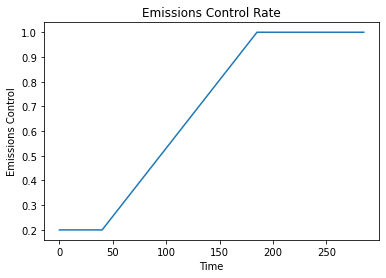

In [4]:
#emissions control rate borrowed from emissions module

#Variables to be changed/deleted later
miu_initial = 0.0
min_miu = 0.2 #0.0 #1.0
min_miu_year = 2055 #9-original #8 in this model  # 2060
max_miu = 1.0 #1.2
max_miu_year = 2200 #38-original #37 in this model #2205

t_min_miu = time_horizon.year_to_timestep(min_miu_year, timestep=1)
t_max_miu = time_horizon.year_to_timestep(max_miu_year, timestep=1)

#Initialize emissions control rate
emissions_control_rate = np.zeros((len(data_loader.REGION_LIST), len(time_horizon.model_time_horizon)))

for t in range(len(time_horizon.model_time_horizon)):
    
    if t < t_min_miu:       # Before time of transition
        emissions_control_rate[:,t] = min_miu
    elif t <= t_max_miu:   # Transition
        # During the transition
        emissions_control_rate[:, t] = min_miu + (max_miu - min_miu) * (t - t_min_miu)/(t_max_miu - t_min_miu)
    else:                   # After the transition
        emissions_control_rate[:, t] = max_miu


#Plot the emissions control rate
#TODO This will be a control Lever
#In RICE50, emissions control rate remains zero in BAU run

from matplotlib import pyplot as plt
plt.plot(emissions_control_rate[0, :])
plt.title("Emissions Control Rate")
plt.xlabel("Time")
plt.ylabel("Emissions Control")
plt.show()

In [5]:
scenarios = 2
model = JUSTICE(start_year = 2015, end_year = 2300, timestep = 1, scenario=scenarios)

In [6]:
model.run(savings_rate = fixed_savings_rate, emissions_control_rate = emissions_control_rate)

print(model.get_outcome_names())

dict_keys(['net_economic_output', 'consumption_per_capita', 'emissions', 'regional_temperature', 'global_temperature', 'economic_damage', 'abatement_cost', 'carbon_price', 'disentangled_utility', 'welfare_utilitarian'])


In [8]:
datasets = model.evaluate(welfare_function=WelfareFunction.UTILITARIAN)

In [10]:
net_output = datasets['net_economic_output']
temp = datasets['global_temperature']
dis_util = datasets['disentangled_utility']

In [11]:
testdf = damages[:,:,0]

## 2. Run

In [ ]:
# Run the model
#temp_emissions = np.zeros((57, 286, 1001))
damage = np.zeros((57, 286, 1001))
abatement_cost = np.zeros((57, 286, 1001))
carbon_price = np.zeros((57, 286))
# Regional temperature array
regional_temperature = np.zeros((57, 286, 1001))
#global_temperature_arr = np.zeros((286, 1001))
set_year = time_horizon.model_time_horizon

for i in (range(len(set_year) )): #- 1

    output = economy.run(scenario = scenarios, timestep=i, savings_rate=fixed_savings_rate[:, i])

    emissions_array = emissions.run_emissions(timestep=i, scenario=scenarios, output=output, emission_control_rate=emissions_control_rate[:,i]) #[:,i,:]   


    if i < (len(set_year) - 1): # Run the model for all timesteps except the last one. Damages and Abatement applies to the next timestep
        global_temperature = climate.compute_temperature_from_emission(i, emissions_array)

        regional_temperature[:,i,:] = downscaler.get_regional_temperature(global_temperature)

        damage[:,i,:] = damage_function.calculate_damage(temperature=regional_temperature[:,i,:], timestep=i)

        # damage[:,i,:] = damage_function.calculate_damage(temperature=regional_temperature, timestep=i)
        abatement_cost[:,i,:] = abatement.calculate_abatement(timestep = i, emissions = emissions_array, emission_control_rate = emissions_control_rate[:,i])
        carbon_price[:,i] = abatement.calculate_carbon_price(timestep = i, emission_control_rate = emissions_control_rate[:,i])
        economy.apply_damage_to_output(timestep=i+1, damage = damage[:,i,:])
        economy.apply_abatement_to_output(timestep=i+1, abatement = abatement_cost[:,i,:])

    # else: # For the last timestep
    #     global_temperature = climate.get_temperature_array(i)
    #print(global_temperature.shape)

    # regional_temperature = downscaler.get_regional_temperature(global_temperature)
    # damage[:,i,:] = damage_function.calculate_damage(temperature=regional_temperature, timestep=i)
    # abatement_cost[:,i,:] = abatement.calculate_abatement(timestep = i, emissions = emissions_array, emission_control_rate = emissions_control_rate[:,i])
    # carbon_price[:,i] = abatement.calculate_carbon_price(timestep = i, emission_control_rate = emissions_control_rate[:,i])


    



In [ ]:
output = economy.__getattribute__('output')
testoutput = output[:,:,0]

In [ ]:
testabate = abatement_cost[:,:,0]


## 3. Evaluate - SWF - for cost benefit analysis

In [ ]:
import matplotlib.pyplot as pl

pl.plot(time_horizon.model_time_horizon, global_temperature_arr ); #regional_temperature[0,:,:]
pl.title('ssp: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

In [ ]:

# cpc = economy.get_consumption_per_capita(scenario=ssp_scenario, savings_rate=fixed_savings_rate)
# test = cpc[:, :, 0]

capital = economy.get_capital_stock(scenario=scenarios, savings_rate=fixed_savings_rate)
test2 = capital[:, :, 0]

In [ ]:
consump = economy.calculate_consumption( savings_rate=fixed_savings_rate)
test3 = consump[:, :, 0]

In [ ]:
lu = climate.get_exogenous_land_use_emissions(fair_scenario)
foss_lu = emissions.get_fossil_and_land_use_emissions(lu)
#fossil_and_land_use_emissions, savings_rate, regional=True
scc = economy.calculate_social_cost_of_carbon(fossil_and_land_use_emissions = foss_lu, savings_rate=fixed_savings_rate, regional=True)

In [ ]:
from src.welfare.utilitarian import calculate_utilitarian_welfare

disentangled_welfare, welfare = calculate_utilitarian_welfare(economy=economy, time_horizon=time_horizon, scenario=scenarios, savings_rate=fixed_savings_rate) 

In [ ]:
economy.pure_rate_of_social_time_preference

In [ ]:
test4 = scc[:, :, 0]

In [ ]:
interest = economy.get_interest_rate(scenario=ssp_scenario, savings_rate=fixed_savings_rate)

test3 = interest[:, :, 0]

In [ ]:
output = economy.__getattribute__('output')
print(output.shape)

testdf = output[:, :, 0]



In [ ]:
baseline_per_capita = economy.__getattribute__('baseline_per_capita_growth')

In [ ]:
testdf = baseline_per_capita[:, :, 0, 0]

In [ ]:
#temperature = model.get_temperature_array()

temp = climate.temperature.loc[dict(scenario=fair_scenario, layer=0)]

# Find the maximum temperature in temperature array
max_temp = np.max(temp[550,:])
print(max_temp)
#find the index of the maximum temperature
max_temp_index = np.where(temp == max_temp)

In [ ]:
climate.calculate_toa_ocean_airborne_fraction()
climate.prepare_output_xarrays()

In [ ]:
# Land use emissions

#Current CO2 AFOLU is in MtCO2/yr in FAIR. For RICE, convert to GtCO2/yr
# fair_scenario = get_climate_scenario(scenarios)
# land_use_emissions = climate.emissions.sel(specie="CO2 AFOLU", scenario=[fair_scenario])
# land_use_emissions = (land_use_emissions.values)[:, 0, :]/ 1e3

In [ ]:
testdf = pd.DataFrame(land_use_emissions[:, 0, 0])
# Plot the land use emissions
testdf.plot()

In [ ]:
fair_scenario = get_climate_scenario(scenarios)
print(fair_scenario)
import matplotlib.pyplot as pl
pl.plot(climate.timebounds, climate.temperature.loc[dict(scenario=fair_scenario, layer=0)], label=climate.configs);
pl.title('ssp: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

In [ ]:
import matplotlib.pyplot as pl
pl.plot(climate.timebounds, climate.temperature.loc[dict(scenario=fair_scenario, layer=0)], label=climate.configs);
pl.title('ssp: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

## Run All Scenarios

In [ ]:
# Temporary test
damage = np.zeros((57, 286, 1001))
abatement_cost = np.zeros((57, 286, 1001))
carbon_price = np.zeros((57, 286))


for idx, scenarios in enumerate(list(Scenario)):
    print(idx, scenarios)

    fair_scenario = get_climate_scenario(idx)
    ssp_scenario = get_economic_scenario(idx)

    # Load the data
    data_loader = DataLoader()

    # Instantiate the TimeHorizon class
    time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

    climate = CoupledFAIR()
    downscaler = TemperatureDownscaler(input_dataset = data_loader)

    climate.fair_justice_run_init(time_horizon=time_horizon, scenarios=fair_scenario)

    damage_function = DamageKalkuhl(input_dataset=data_loader, time_horizon=time_horizon, climate_model=climate)
    abatement = AbatementEnerdata(input_dataset=data_loader, time_horizon=time_horizon)
    no_of_ensembles = climate.__getattribute__('number_of_ensembles')
    print(no_of_ensembles)
    economy = NeoclassicalEconomyModel(input_dataset = data_loader, time_horizon=time_horizon, climate_ensembles=no_of_ensembles)
    emissions = OutputToEmissions(input_dataset=data_loader, time_horizon=time_horizon, climate_ensembles=no_of_ensembles)

    #Create a fixed savings rate
    fixed_savings_rate = np.copy(data_loader.SAVING_RATE_INIT_ARRAY).reshape(-1, 1)
    #fixed_savings_rate Validated with RICE50 for timestep 1 and 5

    #emissions control rate borrowed from emissions module

    #Variables to be changed/deleted later
    miu_initial = 0.0
    min_miu = 0.2 #0.0 #1.0
    min_miu_year = 2055 #9-original #8 in this model  # 2060
    max_miu = 1.0 #1.2
    max_miu_year = 2200 #38-original #37 in this model #2205

    t_min_miu = time_horizon.year_to_timestep(min_miu_year, timestep=1)
    t_max_miu = time_horizon.year_to_timestep(max_miu_year, timestep=1)

    #Initialize emissions control rate
    emissions_control_rate = np.zeros((len(data_loader.REGION_LIST), len(time_horizon.model_time_horizon)))

    for t in range(len(time_horizon.model_time_horizon)):
        
        if t < t_min_miu:       # Before time of transition
            emissions_control_rate[:,t] = min_miu
        elif t <= t_max_miu:   # Transition
            # During the transition
            emissions_control_rate[:, t] = min_miu + (max_miu - min_miu) * (t - t_min_miu)/(t_max_miu - t_min_miu)
        else:                   # After the transition
            emissions_control_rate[:, t] = max_miu



    set_year = time_horizon.model_time_horizon


    for i, years in enumerate(set_year):
        
        t = i+1 #index starts at 0, so add 1 to get the year

        if t != 1: # no need to repeat for the first year

            next_rate = data_loader.SAVING_RATE_INIT_ARRAY + (economy.get_optimal_long_run_savings_rate() - data_loader.SAVING_RATE_INIT_ARRAY)*((t - 1)/(len(set_year) - 1))
            # append to the fixed savings rate array for each year
            fixed_savings_rate = np.column_stack((fixed_savings_rate, next_rate))

    for i in (range(len(set_year) )): #- 1

        output = economy.run(scenario = ssp_scenario, timestep=i, savings_rate=fixed_savings_rate[:, i])

        emissions_array = emissions.run_emissions(timestep=i, scenario=ssp_scenario, output=output, emission_control_rate=emissions_control_rate[:,i]) #[:,i,:]   

        if i < (len(set_year) - 1): # Run the model for all timesteps except the last one. Damages and Abatement applies to the next timestep
            global_temperature = climate.compute_temperature_from_emission(i, emissions_array)
            regional_temperature = downscaler.get_regional_temperature(global_temperature)
            damage[:,i,:] = damage_function.calculate_damage(temperature=regional_temperature, timestep=i)
            abatement_cost[:,i,:] = abatement.calculate_abatement(timestep = i, emissions = emissions_array, emission_control_rate = emissions_control_rate[:,i])
            carbon_price[:,i] = abatement.calculate_carbon_price(timestep = i, emission_control_rate = emissions_control_rate[:,i])
            economy.apply_damage_to_output(timestep=i+1, damage = damage[:,i,:])
            economy.apply_abatement_to_output(timestep=i+1, abatement = abatement_cost[:,i,:])
